In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

## Coriolis Force

The Coriolis Force in the $x$ and $y$ directions is defined as:

$$\frac{1}{\rho}\frac{\partial \tau_x}{\partial z} = -fv$$
$$\frac{1}{\rho}\frac{\partial \tau_y}{\partial z} = -fu$$

where $\tau$ is the wind stress, $\rho$ is the density, $u$ is the East-West velocity, and $v$ is the North-South velocity. <br /><br />

Integrating over the entire Ekman layer:

$$\tau_x = -M_y f$$
$$\tau_y = -M_x f$$

where:

$$M_x = \int_0^z \rho u dz$$
$$M_y = \int_0^z \rho v dz$$

Here $M_x$ and $M_y$ represent the zonal and meridional mass transport terms with units of mass per unit time per unit length. Contrarily to common logic, north-south winds cause mass transport in the East-West direction. <br /><br />

Rewriting in terms of the vertical eddy viscosity term:

$$\frac{\partial \tau_x}{\partial z} = \rho A_z \frac{\partial^2 u}{\partial z^2}$$
$$\frac{\partial \tau_y}{\partial z} = \rho A_z \frac{\partial^2 v}{\partial z^2}$$

where $A_z$ is the vertical eddy viscosity coefficient.<br /><br />

This gives a set of differential equations of the form:

$$A_z \frac{\partial^2 u}{\partial z^2} = -fv$$
$$A_z \frac{\partial^2 v}{\partial z^2} = -fu$$

with boundary conditions:

<ul>
  <li> $(u,v) \to 0$ as $z \to \infty$
  <li> friction equals wind stress at the free surface ($z=0$)
</ul>

If we assume wind is blowing in the y-direction only, this simplifies to:

$$u_E = \pm V_0 cos(\frac{\pi}{4} + \frac{\pi}{D_E} z) e^{\frac{\pi}{D_E} z}$$
$$v_E = V_0 sin(\frac{\pi}{4} + \frac{\pi}{D_E} z) e^{\frac{\pi}{D_E} z}$$

where:
<ul>
<li> $u_E$ and $v_E$ represent Ekman transport in the $u$ and $v$ directions
<li> the plus-minus sign refers to positive in the Northern and negative in the Southern hemisphere
$$V_0 = \frac{\sqrt{2} \pi \tau}{D_E \rho |f|}$$
<li> $\tau$ is the wind stress at the sea surface
$$D_E = \pi (\frac{2 A_z}{|f|})^{1/2}$$
</ul>

In [7]:
def compute_ekman_velocity(wind, depth, latitude=50):

    u_wind, v_wind = wind
    z = depth
    phi = latitude

    rho_air = 1.225  # density of air (kg/m^3)
    rho_water = 1028  # density of seawater (kg/m^3)
    Cd =  1.3e-3 # ranges from (1.1 - 1.5) x 10^-3
    Omega = 7.2910e-5  # rotation rate of Earth (s^-1)
    Az = 5e-2   # m^2 s^−1;

    f = lambda phi : 2 * Omega * np.sin(phi)  # Coriolis parameter

    tau_x = lambda U, V : rho_air * Cd * U * np.sqrt(U**2 + V**2)  # wind stress x-component
    tau_y = lambda U, V : rho_air * Cd * V * np.sqrt(U**2 + V**2)  # wind stress y-component

    algorithm = 'textbook'
    #algorithm = 'wikipedia'

    if algorithm == 'textbook':

        # From Textbook
        V0x = tau_x(u_wind, v_wind) / np.sqrt(rho_water**2 * np.abs(f(phi)) * Az)
        V0y = tau_y(u_wind, v_wind) / np.sqrt(rho_water**2 * np.abs(f(phi)) * Az)
        V0 = np.sqrt(V0x**2 + V0y**2)
        theta = np.pi/2 - np.arctan2(V0y, V0x)

        a = np.sqrt(abs(f(phi))/(2 * Az))

        # note: clockwise rotation
        u_ekman = V0 * np.exp(a * z) * np.cos(np.pi / 4 + a * z) * (np.cos(theta) + np.sin(theta))
        v_ekman = V0 * np.exp(a * z) * np.sin(np.pi / 4 + a * z) * (np.cos(theta) - np.sin(theta))

    if algorithm == 'wikipedia':

        # From Wikipedia

        DE = np.pi * np.sqrt((2 * Az) / np.abs(f(phi)))

        V0x = (np.sqrt(2) * np.pi * tau_x(u_wind, v_wind)) / (DE * rho_air * np.abs(f(phi)))
        V0y = (np.sqrt(2) * np.pi * tau_y(u_wind, v_wind)) / (DE * rho_air * np.abs(f(phi)))
        V0 = np.sqrt(V0x**2 + V0y**2)
        theta = np.pi/2 - np.arctan2(V0y, V0x)

        # note: clockwise rotation
        u_ekman = V0 * np.cos(np.pi / 4 + (np.pi / DE) * z) * np.exp((np.pi / DE) * z) * (np.cos(theta) + np.sin(theta))
        u_ekman = V0 * np.sin(np.pi / 4 + (np.pi / DE) * z) * np.exp((np.pi / DE) * z) * (np.cos(theta) - np.sin(theta))

    return u_ekman, v_ekman 

In [34]:
min_depth = 0
max_depth = 100
depth_step = 10
depth_vec = np.arange(min_depth, max_depth + depth_step, depth_step)
u_ekman_vec = np.zeros(len(depths))
v_ekman_vec = np.zeros(len(depths))

for i, depth in enumerate(depth_vec):

    u_ekman_vec[i], v_ekman_vec[i] = compute_ekman_velocity((10, 0), depth)

In [35]:
90 - np.arctan2(v_ekman_vec[0], u_ekman_vec[0])*180/np.pi

135.0

In [19]:
u_surface_current = 0.1
v_surface_current = 0.1

u_barotropic = u_surface_current - u_ekman_vec[0]
v_barotropic = v_surface_current - v_ekman_vec[0]

In [23]:
u_current_vec = u_barotropic + u_ekman_vec
v_current_vec = v_barotropic + v_ekman_vec
current_magnitude_vec = np.array([np.sqrt(u**2 + v**2) for u, v in zip(u_ekman_vec, v_ekman_vec)])
current_angle_vec = np.array([np.arctan2(v, u) for u, v in zip(u_ekman_vec, v_ekman_vec)])

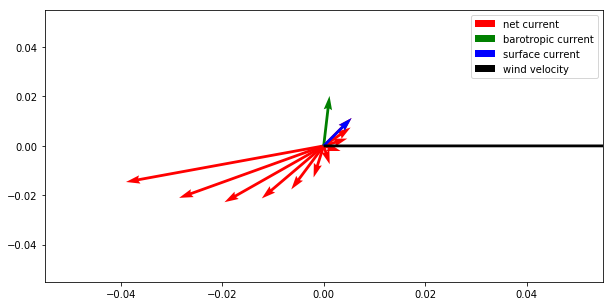

In [41]:
fig = plt.figure(figsize=(10,5))

plt.quiver(np.zeros(len(depths)), np.zeros(len(depths)), u_current_vec, v_current_vec, 
           scale=2, width=0.005, color='red', label='net current')

plt.quiver(0, 0, u_barotropic, v_barotropic, 
           scale=2, width=0.005, color='green', label='barotropic current')

plt.quiver(0, 0, u_surface_current, v_surface_current, 
           scale=2, width=0.005, color='blue', label='surface current')

plt.quiver(0, 0, u_wind, v_wind, 
           scale=2, width=0.005, color='black', label='wind velocity')

plt.legend()
plt.show()

# Old Code

In [42]:
u_wind = 10
v_wind = 5

rho_air = 1.225  # density of air (kg/m^3)
rho_water = 1028  # density of seawater (kg/m^3)
Cd =  1.3e-3 # ranges from (1.1 - 1.5) x 10^-3
Omega = 7.2910e-5  # rotation rate of Earth (s^-1)
Az = 5e-2   # m^2 s^−1;

phi = 50  # latitude (degrees)
f = lambda phi : 2 * Omega * np.sin(phi)  # Coriolis parameter

tau_x = lambda U, V : rho_air * Cd * U * np.sqrt(U**2 + V**2)  # wind stress x-component
tau_y = lambda U, V : rho_air * Cd * V * np.sqrt(U**2 + V**2)  # wind stress y-component

V0x = tau_x(u_wind, v_wind) / np.sqrt(rho_water**2 * np.abs(f(phi)) * Az)
V0y = tau_y(u_wind, v_wind) / np.sqrt(rho_water**2 * np.abs(f(phi)) * Az)
V0 = np.sqrt(V0x**2 + V0y**2)

a = np.sqrt(abs(f(phi))/(2 * Az))

z = 10

u_ekman = V0 * np.exp(a * z) * np.cos(np.pi / 4 + a * z) * np.cos(np.arctan(V0y / V0x))
v_ekman = V0 * np.exp(a * z) * np.sin(np.pi / 4 + a * z) * np.sin(np.arctan(V0y / V0x))

u_ekman, v_ekman 

(0.08469550329666416, 0.06327521715741101)

In [49]:
z0 = -10; dz = -10; nz = 20
z_vec = np.array([z0 + i * dz for i in range(nz)])
u_ekman_vec = np.empty(nz)
v_ekman_vec = np.empty(nz)

for i, z in enumerate(z_vec):
    
    u_ekman_vec[i] = V0 * np.exp(a * z) * np.cos(np.pi / 4 + a * z) * np.cos(np.arctan(V0y / V0x))
    v_ekman_vec[i] = V0 * np.exp(a * z) * np.sin(np.pi / 4 + a * z) * np.sin(np.arctan(V0y / V0x))

In [55]:
x_vec = np.empty(nz); y_vec = np.empty(nz)
x_vec[0] = 0; y_vec[0] = 0

dt = 5  # seconds

for i in range(nz-1):
    
    x_vec[i+1] = x_vec[i] + u_ekman_vec[i] * dt
    y_vec[i+1] = y_vec[i] + v_ekman_vec[i] * dt

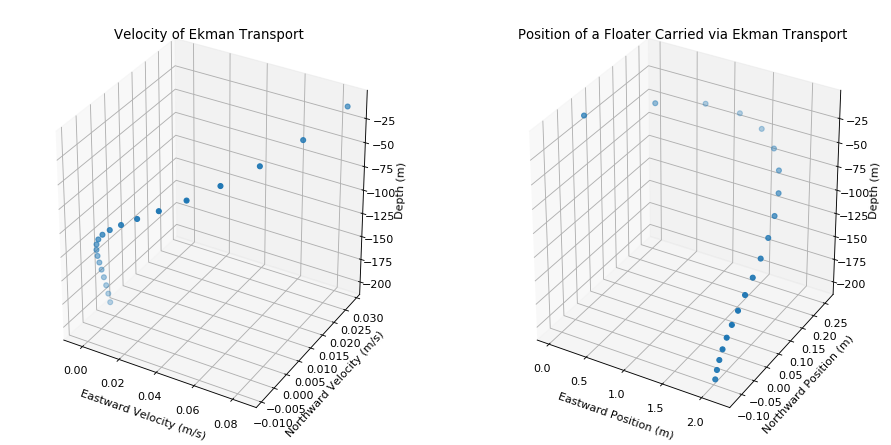

In [63]:
fig = plt.figure(figsize=(14, 7), dpi= 80)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_zlabel('Depth (m)')
ax.set_xlabel('Eastward Velocity (m/s)')
ax.set_ylabel('Northward Velocity (m/s)')
ax.scatter(u_ekman_vec, v_ekman_vec, z_vec)
ax.set_title('Velocity of Ekman Transport')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_zlabel('Depth (m)')
ax.set_xlabel('Eastward Position (m)')
ax.set_ylabel('Northward Position (m)')
ax.scatter(x_vec, y_vec, z_vec)
ax.set_title('Position of a Floater Carried via Ekman Transport')


plt.show()

# From Advanced Ocean Modeling

In [3]:
# Constants

Omega = 7.2925e-5  # rotation rate of Earth (rad/s)
phi = 50  # latitude (degrees)
f = 2 * Omega * np.sin(phi)  # Coriolis parameter
rho_ocean = 1028  # density of the ocean (kg/m^3)
rho_air = 1.225  # density of the air (kg/m^3)
Az = 1  # vertical eddy viscosity coefficient (m^2/s)

In [4]:
# Wind field

u_wind = np.ones((10, 10))
v_wind = np.ones((10, 10))



In [5]:
def init():
    
    nz = 500  # number of vertical grid points
    u = np.zeros(nz)  # horizontal velocity at time level n
    v = np.zeros(nz)  # horizontal velocity at time level n+1
    az = np.ones(nz)  # vertical eddy viscosity
    
    dz = 1.0  # vertical grid spacing is 1 metre
    dt = 5.0  # time step is 5 seconds
    rho = 1028.0  # typical seawater density
    taux = 0.0  # east-west wind stress disabled
    tauy = 0.5  # southerly wind stress is set to 0.5 Pa
    f = 1e-4  # Coriolis parameter

    alpha = dt*f
    beta = 0.25*alpha*alpha

In [6]:
def eddy():
    
    az0 = 5e-2  # uniform eddy viscosity
    winmix = 1e-1  # value near sea surface
    azmin = 4e-3  # local minimum value of eddy viscosity
    zlength = 2.0  # Prandtl mixing length
    
    az = az * az0

In [7]:
def dyn():
    
    a = alpha
    b = 1.0 - beta
    c = 1.0 + beta
    
    # surface boundary conditions

    atop = 0.5*(az[0]+az[1])
    u[0] = u[1] + dz * taux / rho / atop
    v[0] = v[1] + dz * tauy / rho / atop
    
    for i in range(1, nz):
        
        atop = 0.5*(az[i-1]+az[i])
        abot = 0.5*(az[i]+az[i+1])
        diffu = dt * (atop * (u[i-1] - u[i]) / dz - abot * (u[i] - u[i+1]) / dz) / dz
        diffv = dt * (atop * (v[i-1] - v[i]) / dz - abot * (v[i] - v[i+1]) / dz) / dz
        un[i] = (b * u[i] + a * v[i] + 0.5 * a * diffv + diffu) / c
        vn[i] = (b * v[i] - a * u[i] - 0.5 * a * diffu + diffv) / c
        
    # bottom boundary conditions (no stress)
    un[nz+1] = un[nz]
    vn[nz+1] = vn[nz]

In [27]:
# Init

nz = 500  # number of vertical grid points
u = np.zeros(nz); v = np.zeros(nz)  # horizontal velocity at time level n
un = np.zeros(nz); vn = np.zeros(nz)  # horizontal velocity at time level n+1
az = np.ones(nz)  # vertical eddy viscosity

dz = 1.0  # vertical grid spacing is 1 metre
dt = 5.0  # time step is 5 seconds
rho = 1028.0  # typical seawater density
taux = 0.0  # east-west wind stress disabled
tauy = 0.5  # southerly wind stress is set to 0.5 Pa
f = 1e-4  # Coriolis parameter

alpha = dt*f
beta = 0.25*alpha*alpha

ntot = int(5*24*3600/dt)  # runtime is 5 days
time = 0.0

for i in range(ntot-1):
    
    time += dt

    # Eddy

    az0 = 5e-2  # uniform eddy viscosity
    winmix = 1e-1  # value near sea surface
    azmin = 4e-3  # local minimum value of eddy viscosity
    zlength = 2.0  # Prandtl mixing length

    az = az * az0


    # Dyn

    a = alpha
    b = 1.0 - beta
    c = 1.0 + beta

    # surface boundary conditions

    atop = 0.5*(az[0]+az[1])
    u[0] = u[1] + dz * taux / rho / atop
    v[0] = v[1] + dz * tauy / rho / atop

    for i in range(1, nz-1):

        atop = 0.5*(az[i-1] + az[i])
        abot = 0.5*(az[i] + az[i+1])
        diffu = dt * (atop * (u[i-1] - u[i]) / dz - abot * (u[i] - u[i+1]) / dz) / dz
        diffv = dt * (atop * (v[i-1] - v[i]) / dz - abot * (v[i] - v[i+1]) / dz) / dz
        un[i+1] = (b * u[i] + a * v[i] + 0.5 * a * diffv + diffu) / c
        vn[i+1] = (b * v[i] - a * u[i] - 0.5 * a * diffu + diffv) / c

        
    # bottom boundary conditions (no stress)
    
    un[nz-1] = un[nz-2]
    vn[nz-1] = vn[nz-2]
    
    for i in range(nz):
        
        u[i] = un[i]; v[i] = vn[i]

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [ ]:
plt.plot(un)

In [19]:
x = np.zeros(nz); y = np.zeros(nz); t = np.zeros(nz)
t[0] = 0; x[0] = 0; y[0] = 0
for i in range(nz-1):
    t[i+1] = t[i] + dt
    x[i+1] = x[i] + un[i]*dt
    y[i+1] = y[i] + vn[i]*dt

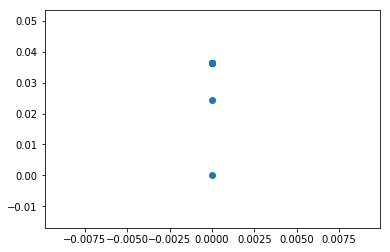

In [21]:
plt.scatter(x, y)

In [28]:
data = np.loadtxt('/home/evankielley/Downloads/Updated_Exercises_March_2015/Exercise1/uvprof1.dat')

In [33]:
z = data[:, 0]
u = data[:, 1]
v = data[:, 2]

In [35]:
x = np.zeros(nz); y = np.zeros(nz)

for i in range(nz-1):
    
    x[i+1] = x[i] + u[i]*dt
    y[i+1] = y[i] + v[i]*dt
    

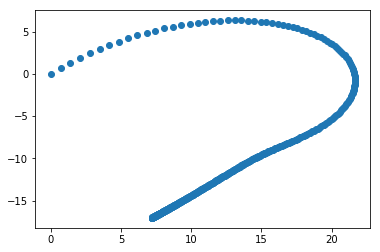

In [37]:
plt.scatter(x, y)

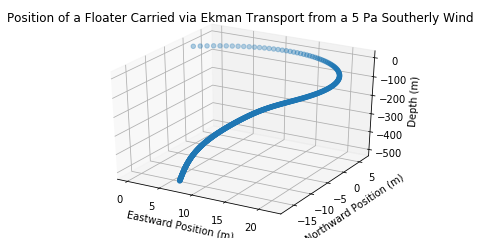

In [45]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

#mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.set_zlabel('Depth (m)')
#ax.set_xlabel('Eastward Velocity (m/s)')
#ax.set_ylabel('Northward Velocity (m/s)')
#ax.scatter(u, v, z)
#ax.set_title('Ekman Transport from 5 Pa Southerly Wind')

ax.set_xlabel('Eastward Position (m)')
ax.set_ylabel('Northward Position (m)')
ax.scatter(x, y, z)
ax.set_title('Position of a Floater Carried via Ekman Transport from a 5 Pa Southerly Wind')


plt.show()